In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7463402400480229633
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1389890540166240467
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import urllib.request
import zipfile

url = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
filename = "train.zip"

urllib.request.urlretrieve(url, filename)

with zipfile.ZipFile('train.zip') as zip_ref:
    zip_ref.extractall()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 52, 52, 96)        2496      
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 140)       121100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 140)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 240)       302640    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 240)         0

100%|██████████| 43/43 [00:06<00:00,  6.32it/s]


Epoch 1/50
1103/1103 [==============================] - 18s 11ms/step - loss: 2.4384 - accuracy: 0.3278 - val_loss: 0.6246 - val_accuracy: 0.8317
Epoch 2/50
1103/1103 [==============================] - 11s 10ms/step - loss: 0.9133 - accuracy: 0.7086 - val_loss: 0.1566 - val_accuracy: 0.9602
Epoch 3/50
1103/1103 [==============================] - 11s 10ms/step - loss: 0.4083 - accuracy: 0.8724 - val_loss: 0.0640 - val_accuracy: 0.9847
Epoch 4/50
1103/1103 [==============================] - 11s 10ms/step - loss: 0.2374 - accuracy: 0.9273 - val_loss: 0.0355 - val_accuracy: 0.9916
Epoch 5/50
1103/1103 [==============================] - 12s 11ms/step - loss: 0.1849 - accuracy: 0.9460 - val_loss: 0.0931 - val_accuracy: 0.9750
Epoch 6/50
1103/1103 [==============================] - 11s 10ms/step - loss: 0.1483 - accuracy: 0.9579 - val_loss: 0.0879 - val_accuracy: 0.9742
Epoch 7/50
1103/1103 [==============================] - 11s 10ms/step - loss: 0.1288 - accuracy: 0.9634 - val_loss: 0.0218 -

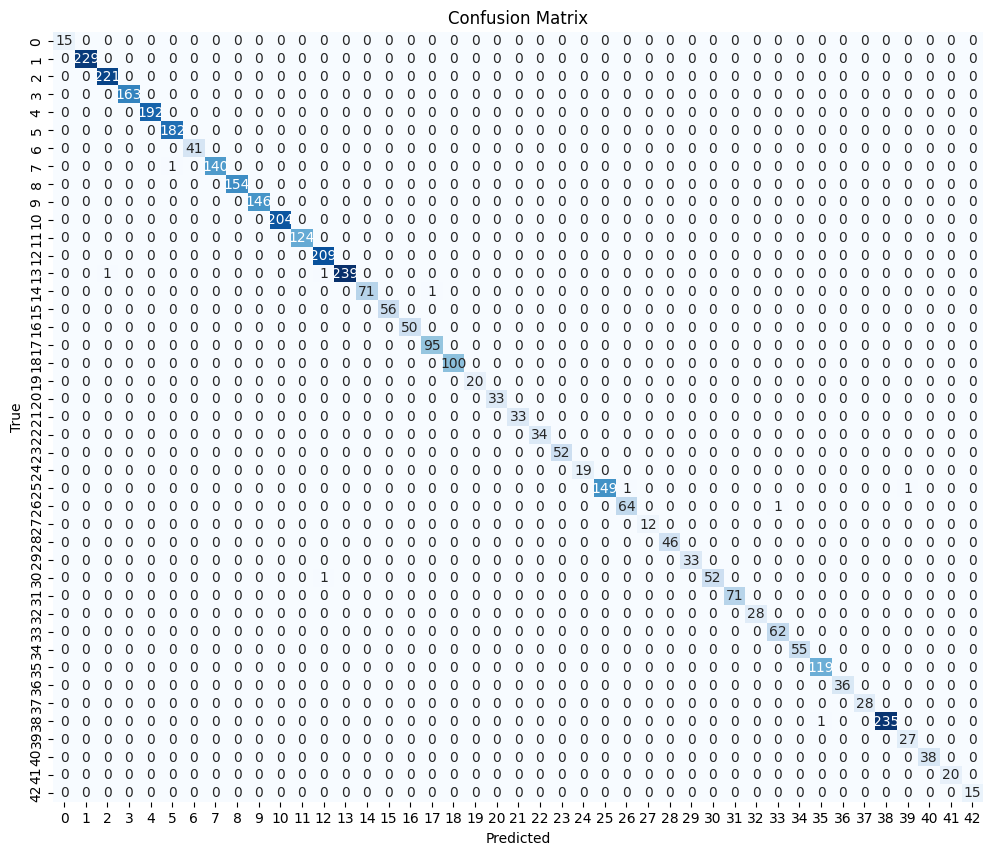

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
import numpy as np
from tqdm import tqdm


def preprocess_img(img):
    if type(img) is None:
        return
    if img.shape != (56, 56):
        img = cv2.resize(img, (56, 56))
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def load_data(root_dir):
    images = []
    labels = []

    for folder in tqdm(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if 'ppm' in filename:
                    img_path = os.path.join(folder_path, filename)
                    img = preprocess_img(cv2.imread(img_path))
                    images.append(img)
                    labels.append(int(folder))

    return np.array(images), np.array(labels)


model = Sequential()

model.add(Conv2D(96, (5, 5), strides=(1, 1), input_shape=(56, 56, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(140, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(240, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

X, y = load_data('/content/GTSRB/Final_Training/Images/')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

from keras.utils import to_categorical

num_classes = 43
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

model.fit(X_train, y_train_categorical, batch_size=32, epochs=50, validation_data=(X_test, y_test_categorical))

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

plot = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(plot, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
model.save_weights('model.h5')
